In [1]:
# import the necessary packages
import numpy as np
import cv2
import argparse
import matplotlib.pyplot as plt
from skimage.filters import threshold_adaptive

In [2]:
def OrderPoints(points):
    # initialzie a list of coordinates that will be ordered
    # such that the first entry in the list is the top-left,
    # the second entry is the top-right, the third is the
    # bottom-right, and the fourth is the bottom-left
    rect = np.zeros((4,2), dtype = "float32")
    
    # the top-left point will have the smallest sum, whereas
    # the bottom-right point will have the largest sum
    calc = points.sum(axis=1)    
    rect[0] = points[np.argmin(calc)]
    rect[2] = points[np.argmax(calc)]
    
    # now, compute the difference between the points, the
    # top-right point will have the smallest difference,
    # whereas the bottom-left will have the largest difference
    calc = np.diff(points)    
    rect[1] = points[np.argmax(calc)]
    rect[3] = points[np.argmin(calc)]
    
    return rect

def four_point_transform(image, pts):
    # obtain a consistent order of the points and unpack them
    # individually
    rect = order_points(pts)
    (tl, tr, br, bl) = rect

    # compute the width of the new image, which will be the
    # maximum distance between bottom-right and bottom-left
    # x-coordiates or the top-right and top-left x-coordinates
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    # compute the height of the new image, which will be the
    # maximum distance between the top-right and bottom-right
    # y-coordinates or the top-left and bottom-left y-coordinates
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    # now that we have the dimensions of the new image, construct
    # the set of destination points to obtain a "birds eye view",
    # (i.e. top-down view) of the image, again specifying points
    # in the top-left, top-right, bottom-right, and bottom-left
    # order
    dst = np.array([
    [0, 0],
    [maxWidth - 1, 0],
    [maxWidth - 1, maxHeight - 1],
    [0, maxHeight - 1]], dtype = "float32")

    # compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

    # return the warped image
    return warped

In [3]:
# load the image and compute the ratio of the old height
# to the new height, clone it, and resize it
image = cv2.imread("./images/1.jpg")
ratio =  500.0/image.shape[0]
orig = image.copy()
image = cv2.resize(image, (500,int(image.shape[1]*ratio)))
print(ratio,image.shape,orig.shape)
# convert the image to grayscale, blur it, and find edges
# in the image
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)
edged = cv2.Canny(gray, 40, 200)
 
# show the original image and the edge detected image
print ("STEP 1: Edge Detection")
cv2.imshow("OrigImage", orig)
cv2.imshow("Image", image)
cv2.imshow("Edged", edged)
cv2.waitKey(0)
cv2.destroyAllWindows()


0.15318627450980393 (375, 500, 3) (3264, 2448, 3)
STEP 1: Edge Detection


STEP 2: Find contours of paper
[[ 161.   60.]
 [  37.  266.]
 [ 336.  316.]
 [ 445.  125.]]


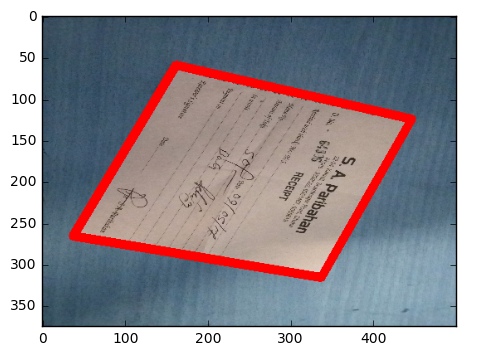

In [6]:

im,cnts, _ = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:5]
# loop over the contours
points = []
for c in cnts:
    for p in c:
        points.append(p)
        #print(p)

npPoints = np.asarray(points)
npPoints = np.reshape(npPoints,(npPoints.shape[0],2))
points = OrderPoints(npPoints)
# show the contour (outline) of the piece of paper
print ("STEP 2: Find contours of paper")
color=[255, 0, 0]
print(points)
cv2.line(image, (points[0][0],points[0][1]), (points[1][0],points[1][1]), color, 10)
cv2.line(image, (points[1][0],points[1][1]), (points[2][0],points[2][1]), color, 10)
cv2.line(image, (points[2][0],points[2][1]), (points[3][0],points[3][1]), color, 10)
cv2.line(image, (points[3][0],points[3][1]), (points[0][0],points[0][1]), color, 10)

cv2.imshow("Outline", image)
cv2.waitKey(0)
cv2.destroyAllWindows()
plt.imshow(image)
plt.show()